# OAK diff-via-mappings command

This notebook is intended as a supplement to the [main OAK CLI docs](https://incatools.github.io/ontology-access-kit/cli.html).

This notebook provides examples for the `diff-via-mappings` command, which can be used to **find differences between two ontologies based on mappings between them**

For more on mappings, see [Mappings](https://incatools.github.io/ontology-access-kit/guide/mappings.html) in the OAK guide.


## Help Option

You can get help on any OAK command using `--help`

In [1]:
!runoak diff-via-mappings --help

Usage: runoak diff-via-mappings [OPTIONS] [TERMS]...

  Calculates cross-ontology diff using mappings

  Given a pair of ontologies, and mappings that connect terms in both
  ontologies, this command will perform a structural comparison of all mapped
  pairs of terms

  Example:

      runoak -i sqlite:obo:uberon diff-via-mappings --other-input
      sqlite:obo:zfa  --source UBERON --source ZFA -O csv

  Note the above command does not have any mapping file specified; the
  mappings that are distributed within each ontology is used (in this case,
  Uberon contains mappings to ZFA)

  If the mappings are provided externally:

      runoak -i ont1.obo diff-via-mappings --other-input ont2.obo --mapping-
      input mappings.sssom.tsv

  (in the above example, --source is not passed, so all mappings are tested)

  If there are no existing mappings, you can use the lexmatch command to
  generate them:

      runoak -i ont1.obo diff-via-mappings -a ont2.obo lexmatch -o
      mappings.sssom.t

## Example: Diff between two anatomy ontologies

To illustrate usage, we will calculate the diff between [UBERON](https://obofoundry.org/ontology/uberon) (a multi-species anatomy ontology) and [ZFA](https://obofoundry.org/ontology/zfa) (an anatomy ontology for zebrafish).

Note that rather than provide a set of external mappings, we will use the mappings present in both ontologies (in this case, UBERON has xrefs to ZFA).

To simplify the comparison, we will only consider [is_a](https://incatools.github.io/ontology-access-kit/glossary.html#term-IS_A) and [part_of](https://incatools.github.io/ontology-access-kit/glossary.html#term-Part-Of) relationships. This is specified using the `--predicates` (`-p`) option

In [5]:
!runoak -i sqlite:obo:uberon diff-via-mappings --other-input \
      sqlite:obo:zfa  --source UBERON --source ZFA -p i,p -O csv -o output/uberon-zfa-diff.csv

## Analyzing the results using Pandas

Note that we asked for the output as a tabular file (`-O csv`), rather than native YAML. You could take the tabular output, analyze it in a spreadsheet, etc. Here we will use the Python pandas library.

In [8]:
import pandas as pd
df=pd.read_csv("output/uberon-zfa-diff.csv", sep="\t").fillna("")

In [9]:
df

,left_subject_id,left_object_id,left_predicate_id,category,left_subject_label,left_object_label,left_predicate_label,right_subject_id,right_object_id,right_predicate_ids,right_subject_label,right_object_label,right_predicate_labels,left_subject_is_functional,left_object_is_functional,subject_mapping_predicate,object_mapping_predicate,right_intermediate_ids,subject_mapping_cardinality,object_mapping_cardinality
0,UBERON:0000002,UBERON:0000995,BFO:0000050,MissingMapping,uterine cervix,uterus,,,,,,,,,,,,,1:0,
1,UBERON:0000002,UBERON:0001560,rdfs:subClassOf,MissingMapping,uterine cervix,neck of organ,,,,,,,,,,,,,1:0,
2,UBERON:0000002,UBERON:0005156,rdfs:subClassOf,MissingMapping,uterine cervix,reproductive structure,,,,,,,,,,,,,1:0,
3,UBERON:0000003,UBERON:0000033,BFO:0000050,MissingMapping,naris,head,,,,,,,,,,,,,1:0,
4,UBERON:0000003,UBERON:0005725,BFO:0000050,MissingMapping,naris,olfactory system,,,,,,,,,,,,,1:0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36336,ZFA:0009401,ZFA:0009000,rdfs:subClassOf,MissingMapping,lens fiber cell,cell,,,,,,,,,,,,,1:0,
36337,ZFA:0009402,ZFA:0005065,BFO:0000050,MissingMapping,heart valve cell,heart valve,,,,,,,,,,,,,1:0,
36338,ZFA:0009402,ZFA:0009000,rdfs:subClassOf,MissingMapping,heart valve cell,cell,,,,,,,,,,,,,1:0,
36339,ZFA:0009403,ZFA:0009402,rdfs:subClassOf,MissingMapping,heart valve interstitial cell,heart valve cell,,,,,,,,,,,,,1:0,


In [20]:
df["left_source"] = df.apply(lambda x: x.left_subject_id.split(":")[0], axis=1)

## Plotting mapping diff categories

The diff tool works by taking each relationship/edge in the "left" ontology (here all UBERON and all ZFA edges
are considered) and trying to map it to a relationship in the "right" ontology.

The mapping is assigned a category from the [cross-ontology-diff:DiffCategory](https://w3id.org/oak/cross-ontology-diff/DiffCategory) enumeration.

(note that like many OAK operations, the output conforms to a data model that makes its semantics explicit)

We will use seaborn/matplotlib to plot the category counts

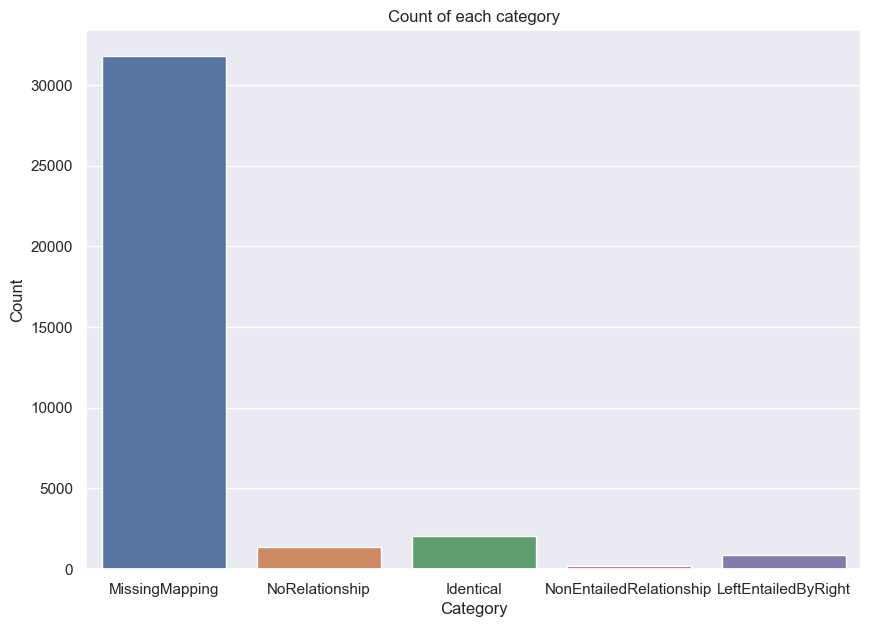

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# Set the figure size
plt.figure(figsize=(10, 7))

sns.countplot(data=df, x='category')
plt.title('Count of each category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

the dominant category is MissingMapping. This means that either/both subject and object of the left edge could not be matched in the right ontology. It is not surprising there are so many, because Uberon covers more species.

### Breaking down by predicate, and using log scale

We can get a more detailed view by breaking down the counts by the predicate of the left edge.

We will also use a log scale

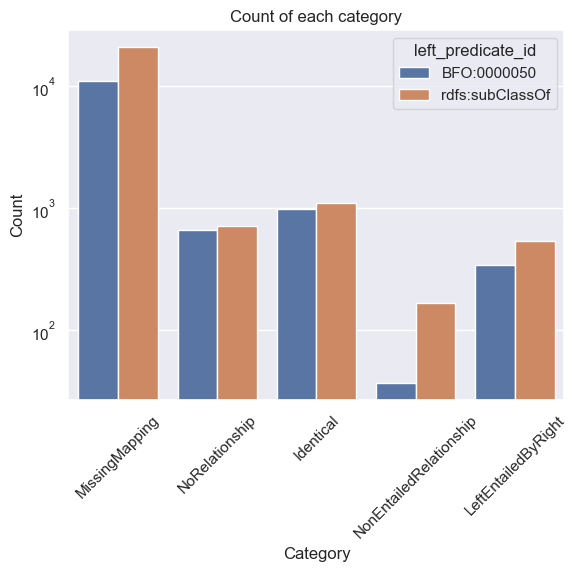

In [14]:
sns.countplot(data=df, x='category', hue="left_predicate_id")
plt.title('Count of each category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.yscale('log')
plt.xticks(rotation=45) # Make x-axis labels diagonal
plt.show()

## Exploring categories

### Non-entailed relationships

i.e. this is an edge in UBERON that corresponds to a different kind of edge in ZFA (or vice versa), where the former
doesn't subsume the latter.

For example, in UBERON PNS *part_of* NS; in ZFA PNS *is_a* NS

In [17]:
df.query("category=='NonEntailedRelationship'")

,left_subject_id,left_object_id,left_predicate_id,category,left_subject_label,left_object_label,left_predicate_label,right_subject_id,right_object_id,right_predicate_ids,right_subject_label,right_object_label,right_predicate_labels,left_subject_is_functional,left_object_is_functional,subject_mapping_predicate,object_mapping_predicate,right_intermediate_ids,subject_mapping_cardinality,object_mapping_cardinality
22,UBERON:0000010,UBERON:0001016,BFO:0000050,NonEntailedRelationship,peripheral nervous system,nervous system,,ZFA:0000142,ZFA:0000396,rdfs:subClassOf,peripheral nervous system,nervous system,,,,,,,,
24,UBERON:0000011,UBERON:0002410,BFO:0000050,NonEntailedRelationship,parasympathetic nervous system,autonomic nervous system,,ZFA:0001575,ZFA:0001574,rdfs:subClassOf,parasympathetic nervous system,autonomic nervous system,,,,,,,,
29,UBERON:0000013,UBERON:0002410,BFO:0000050,NonEntailedRelationship,sympathetic nervous system,autonomic nervous system,,ZFA:0001576,ZFA:0001574,rdfs:subClassOf,sympathetic nervous system,autonomic nervous system,,,,,,,,
196,UBERON:0000095,UBERON:0002342,BFO:0000050,NonEntailedRelationship,cardiac neural crest,neural crest,,ZFA:0001648,ZFA:0000045,rdfs:subClassOf,cardiac neural crest,neural crest,,,,,,,,
725,UBERON:0000936,UBERON:0003931,BFO:0000050,NonEntailedRelationship,posterior commissure,diencephalic white matter,,ZFA:0000320,ZFA:0000338,rdfs:subClassOf,caudal commissure,diencephalic white matter,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35155,ZFA:0005661,ZFA:0001488,rdfs:subClassOf,NonEntailedRelationship,olfactory bulb glomerulus,multi-tissue structure,,UBERON:0005387,UBERON:0000481,BFO:0000050|RO:0002131|RO:0002323,olfactory glomerulus,multi-tissue structure,,,,,,,,
35458,ZFA:0005829,ZFA:0005249,rdfs:subClassOf,NonEntailedRelationship,Schlemm's canal,vasculature,,UBERON:0004029,UBERON:0002049,BFO:0000050|RO:0002131|RO:0002323,canal of Schlemm,vasculature,,,,,,,,
35680,ZFA:0007017,ZFA:0001477,rdfs:subClassOf,NonEntailedRelationship,posterior neural plate,portion of tissue,,UBERON:0003057,UBERON:0000479,BFO:0000050|RO:0002131|RO:0002323,chordal neural plate,tissue,,,,,,,,
35701,ZFA:0007037,ZFA:0001477,rdfs:subClassOf,NonEntailedRelationship,posterior neural tube,portion of tissue,,UBERON:0003076,UBERON:0000479,BFO:0000050|RO:0002131|RO:0002202|RO:0002254|R...,posterior neural tube,tissue,,,,,,,,


### No relationship

In this case, the edge in UBERON has no corresponding edge in ZFA (or vice versa), entailed or otherwise

In [18]:
df.query("category=='NoRelationship'")

,left_subject_id,left_object_id,left_predicate_id,category,left_subject_label,left_object_label,left_predicate_label,right_subject_id,right_object_id,right_predicate_ids,right_subject_label,right_object_label,right_predicate_labels,left_subject_is_functional,left_object_is_functional,subject_mapping_predicate,object_mapping_predicate,right_intermediate_ids,subject_mapping_cardinality,object_mapping_cardinality
7,UBERON:0000004,UBERON:0000475,rdfs:subClassOf,NoRelationship,nose,organism subdivision,,ZFA:0000047,ZFA:0001308,,peripheral olfactory organ,organism subdivision,,,,,,,,
188,UBERON:0000089,UBERON:0004750,BFO:0000050,NoRelationship,hypoblast (generic),blastoderm,,ZFA:0000117,ZFA:0001176,,hypoblast,blastoderm,,,,,,,,
647,UBERON:0000471,UBERON:0003103,BFO:0000050,NoRelationship,compound organ component,compound organ,,ZFA:0001489,ZFA:0000496,,compound organ component,compound organ,,,,,,,,
661,UBERON:0000479,UBERON:0000468,BFO:0000050,NoRelationship,tissue,multicellular organism,,ZFA:0001477,ZFA:0001094,,portion of tissue,whole organism,,,,,,,,
663,UBERON:0000480,UBERON:0000468,BFO:0000050,NoRelationship,anatomical group,multicellular organism,,ZFA:0001512,ZFA:0001094,,anatomical group,whole organism,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35714,ZFA:0007057,ZFA:0005297,rdfs:subClassOf,NoRelationship,ocular blood vessel,cranial blood vessel,,UBERON:0002203,UBERON:0011362,,vasculature of eye,cranial blood vasculature,,,,,,,,
35715,ZFA:0007058,ZFA:0000012,BFO:0000050,NoRelationship,roof plate,central nervous system,,UBERON:0003054,UBERON:0001017,,roof plate,central nervous system,,,,,,,,
35716,ZFA:0007058,ZFA:0001488,rdfs:subClassOf,NoRelationship,roof plate,multi-tissue structure,,UBERON:0003054,UBERON:0000481,,roof plate,multi-tissue structure,,,,,,,,
35720,ZFA:0007071,ZFA:0001477,rdfs:subClassOf,NoRelationship,flexural organ,portion of tissue,,UBERON:0011577,UBERON:0000479,,flexural organ,tissue,,,,,,,,


### LeftEntailedByRight

in this case UBERON has a direct edge that corresponds to two or more direct edges in ZFA (or vice versa)

In this case the edges must chain together via OWL semantics.

for example, UBERON has `ganglion part-of nervous system`, ZFA has `ganglion part-of PNS is-a nervous system`

In [25]:
df.query("category=='LeftEntailedByRight'")

,left_subject_id,left_object_id,left_predicate_id,category,left_subject_label,left_object_label,left_predicate_label,right_subject_id,right_object_id,right_predicate_ids,...,right_object_label,right_predicate_labels,left_subject_is_functional,left_object_is_functional,subject_mapping_predicate,object_mapping_predicate,right_intermediate_ids,subject_mapping_cardinality,object_mapping_cardinality,left_source
35,UBERON:0000016,UBERON:0000949,BFO:0000050,LeftEntailedByRight,endocrine pancreas,endocrine system,,ZFA:0001260,ZFA:0001158,BFO:0000050|RO:0002131|RO:0002202,...,endocrine system,,,,,,,,,UBERON
91,UBERON:0000045,UBERON:0001016,BFO:0000050,LeftEntailedByRight,ganglion,nervous system,,ZFA:0000190,ZFA:0000396,BFO:0000050|RO:0002131,...,nervous system,,,,,,,,,UBERON
182,UBERON:0000086,UBERON:0000992,BFO:0000050,LeftEntailedByRight,zona pellucida,ovary,,ZFA:0001111,ZFA:0000403,BFO:0000050|RO:0002131,...,ovary,,,,,,,,,UBERON
645,UBERON:0000467,UBERON:0000061,rdfs:subClassOf,LeftEntailedByRight,anatomical system,anatomical structure,,ZFA:0001439,ZFA:0000037,BFO:0000050|RO:0002131|rdfs:subClassOf,...,anatomical structure,,,,,,,,,UBERON
658,UBERON:0000477,UBERON:0001062,rdfs:subClassOf,LeftEntailedByRight,anatomical cluster,anatomical entity,,ZFA:0001478,ZFA:0100000,rdfs:subClassOf,...,zebrafish anatomical entity,,,,,,,,,UBERON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35706,ZFA:0007043,ZFA:0001477,rdfs:subClassOf,LeftEntailedByRight,hindbrain neural tube,portion of tissue,,UBERON:2007043,UBERON:0000479,BFO:0000050|RO:0002131|RO:0002202|RO:0002254|R...,...,tissue,,,,,,,,,ZFA
35711,ZFA:0007048,ZFA:0005145,rdfs:subClassOf,LeftEntailedByRight,ventral intermandibularis posterior,muscle,,UBERON:2007048,UBERON:0001630,RO:0002131|RO:0002202|RO:0002254|RO:0002258|RO...,...,muscle organ,,,,,,,,,ZFA
35717,ZFA:0007068,ZFA:0001486,rdfs:subClassOf,LeftEntailedByRight,otic epithelium,epithelium,,UBERON:0003249,UBERON:0000483,RO:0002131|RO:0002323|rdfs:subClassOf,...,epithelium,,,,,,,,,ZFA
35721,ZFA:0007072,ZFA:0000010,BFO:0000050,LeftEntailedByRight,blood sinus,cardiovascular system,,UBERON:0006615,UBERON:0004535,BFO:0000050|RO:0002131|RO:0002202|RO:0002254|R...,...,cardiovascular system,,,,,,,,,ZFA


## Breaking things down by direction

By default, the command will do diffs in both directions, unless `--no-bidirectional` is passed.

We can post-hoc break the summary statistics down based on the source of the left term

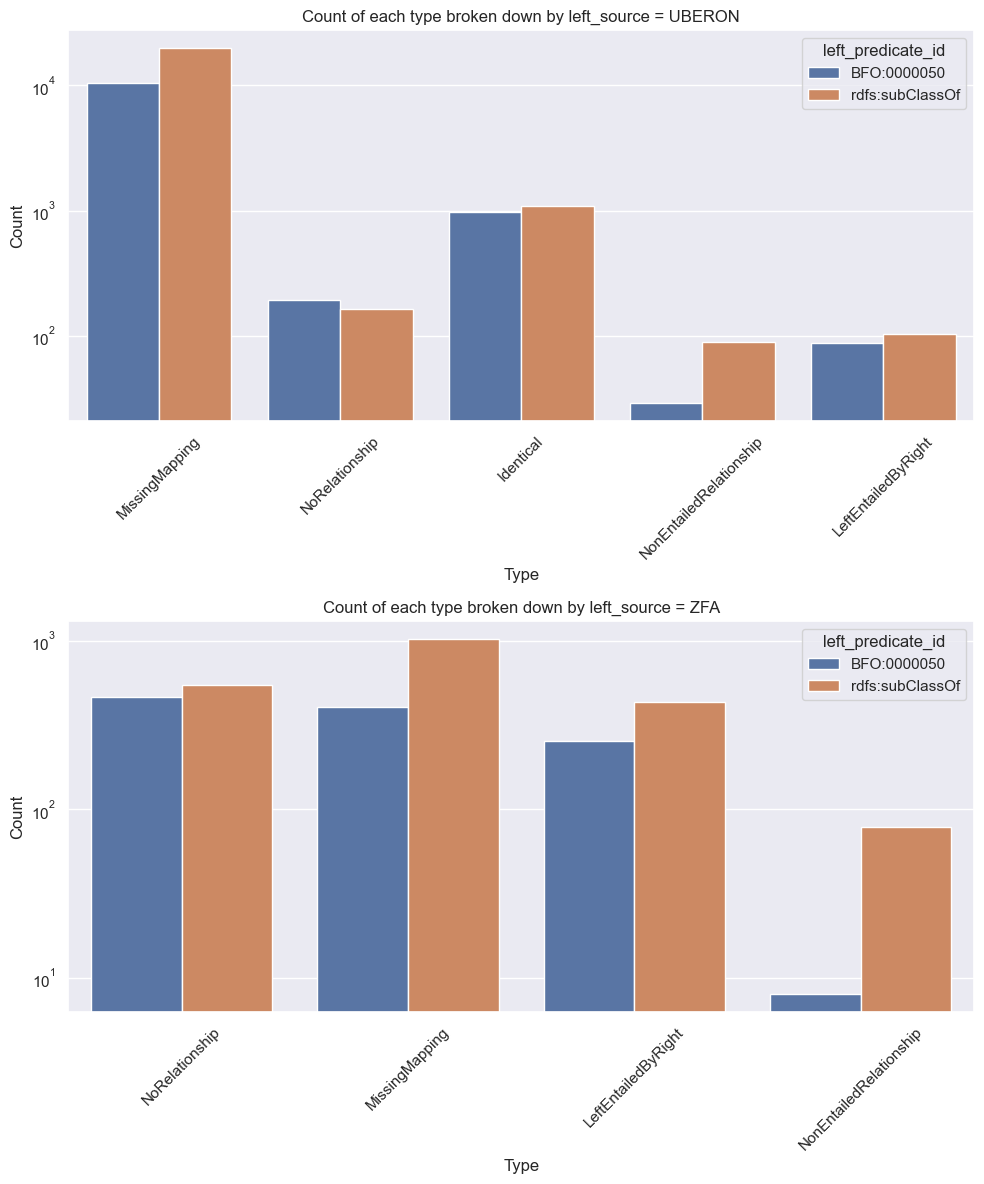

In [24]:
unique_srcs = df['left_source'].unique()
n_unique = len(unique_srcs)
fig, axs = plt.subplots(nrows=n_unique, figsize=(10, 6*n_unique))

for ax, left_source in zip(axs, unique_srcs):
    sub_df = df[df['left_source'] == left_source]
    sns.countplot(data=sub_df, x='category', hue='left_predicate_id', ax=ax)
    ax.set_title(f'Count of each type broken down by left_source = {left_source}')
    ax.set_xlabel('Type')
    ax.set_ylabel('Count')
    ax.set_yscale('log') # Make y-axis logarithmic
    ax.tick_params(axis='x', rotation=45) # Make x-axis labels diagonal

plt.tight_layout() # Ensure layout is tight so labels don't get cut off
plt.show()


As expected `MissingMapping` dominates the Uberon->ZFA direction. Note this is not actually "missing" in the sense of incomplete, we expect most edges in uberon to be non-mappable to ZFA due to difference in taxonomic scope.